In [ ]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Step1:- Importing the required libraries

In [ ]:
# Installing and importing all the required dependencies and libraries
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Step 2:- Data loading and Preprocessing

In [ ]:
image_path = "/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images"
dir_Flickr_text = "/content/drive/MyDrive/FLICKR8K/FLICKR8K/captions.txt"
jpgs = os.listdir(image_path)

print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 16182


In [ ]:
# Creating a dataFrame having filename and the corresponding caption in each row
 
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split(',')
   if len(col) == 1:
       continue
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","caption"])
data = data.reindex(columns =['filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

,filename,caption
0,image,caption
1,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
2,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
3,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
4,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...


In [ ]:
len(data)

40456

In [ ]:
# Dropping the first row as it is a header row which is already defined

data.drop(0,inplace=True)

In [ ]:
len(data)

40455

In [ ]:
data

,filename,caption
1,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
2,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
3,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
4,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
5,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...
...,...,...
40451,997722733_0cb5439472.jpg,a man in a pink shirt climbs a rock face
40452,997722733_0cb5439472.jpg,a man is rock climbing high in the air .
40453,997722733_0cb5439472.jpg,a person in a red shirt climbing up a rock fac...
40454,997722733_0cb5439472.jpg,a rock climber in a red shirt .


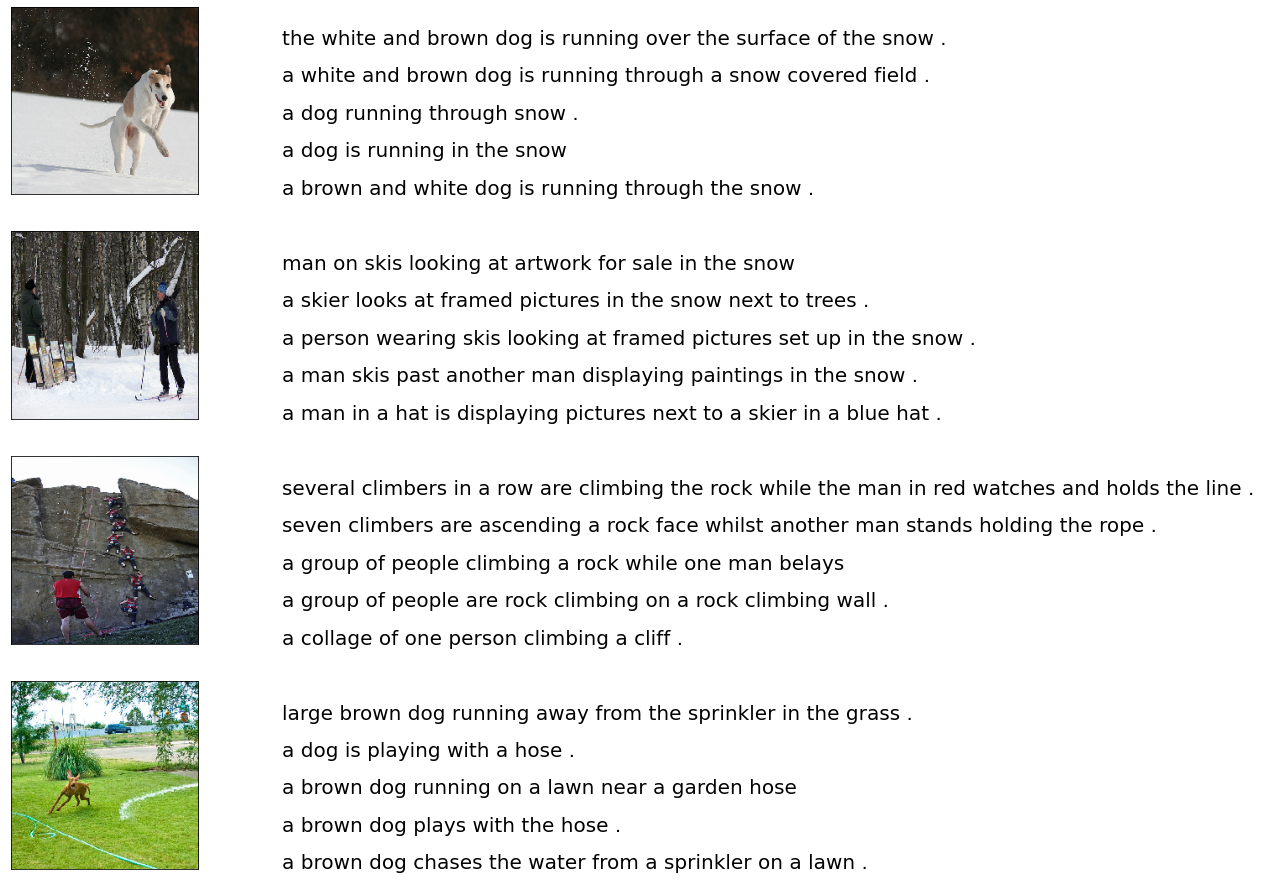

In [ ]:
# visualising some of the captions and images in the Flickr8k Dataset
 
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
   filename = image_path + '/' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

In [ ]:
# Creating the vocabulary from the captions

vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8871


In [ ]:
# Basic Text preprocessing(removal of punctuations,single character text, numeric characters)

def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

In [ ]:
# creating new vocabulary of cleaned text(we can observe reduction in vocab size)

clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8182


In [ ]:
# Adding <start> and <end> tag before and after each caption so that our encoder can identify start and end of a caption

PATH = "/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/"
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [ ]:
# Creating a list of sources of all the images so that we can access them one after one
all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/1001773457_577c3a7d70.jpg']

In [ ]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [ ]:
# Taking only 40,000 datapoints so that we can have 625 batches of 64 batch size
def data_limiter(num,total_captions,all_img_name_vector):
 train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
 train_captions = train_captions[:num]
 img_name_vector = img_name_vector[:num]
 return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [ ]:
img_name_vector

['/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/1956678973_223cb1b847.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/3256603992_67312b5a36.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/2938747424_64e64784f0.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/2831314869_5025300133.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/516725192_c9cdd63878.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/537559285_29be110134.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/2172493537_128bc8b187.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/2287023569_fd7a9c60b8.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/3191805046_77c334b506.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/2869491449_1041485a6b.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/140377584_12bdbdf2f8.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/132489044_3be606baf7.jpg',
 '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/2346401538_f5e8da6

Step 3:- Model Definition

We will use the VGG16 architecture trained on imagenet dataset.Also Since we donot need to classify the images we will remove the last layer.

In [ ]:
# we are makiing a function which we resize all our images into 224*224*3 which is required for VGG 16 as input

def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
______________________________________________________________

In [ ]:
encode_train = sorted(set(img_name_vector))


In [ ]:
len(encode_train)

8091

In [ ]:

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:
image_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>

In [ ]:
for img,path in image_dataset:
  for p in path:
   path_of_feature = p.numpy().decode("utf-8")
   print(path_of_feature,split()[-1])
   break
  break

/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/1000268201_693b08cb0e.jpg


In [ ]:
%%time
permanent_path = '/content/drive/MyDrive/FLICKR8K/FLICKR8K/numpy_images/'
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

 for bf, p in zip(batch_features, path):
   path_of_feature = p.numpy().decode("utf-8")
   path_of_feature = permanent_path+ path_of_feature.split('/')[-1] 
   np.save(path_of_feature, bf.numpy())


100%|██████████| 127/127 [26:59<00:00, 12.75s/it]

CPU times: user 1min 47s, sys: 6.15 s, total: 1min 54s
Wall time: 26min 59s


In [ ]:
top_k = 8000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
train_captions[:3]

['<start>  several children leaping into pile of leaves on the ground <end>',
 '<start>  man hiking in the wilderness giving the camera thumbs up <end>',
 '<start>  white dog is running through the water onto the shore <end>']

In [ ]:
train_seqs[:3]

[[2, 185, 60, 332, 63, 506, 12, 328, 6, 5, 169, 3],
 [2, 11, 569, 4, 5, 2841, 895, 5, 94, 1270, 53, 3],
 [2, 14, 9, 7, 32, 33, 5, 24, 238, 5, 284, 3]]

In [ ]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 31 : 2


In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [ ]:
def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
class VGG16_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(VGG16_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x   

In [ ]:
def rnn_type(units):
   if tf.test.is_gpu_available():
       return tf.compat.v1.keras.layers.CuDNNLSTM(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
   else:
       return tf.keras.layers.GRU(units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_activation='sigmoid',
                                  recurrent_initializer='glorot_uniform')

In [ ]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
 def __init__(self, embedding_dim, units, vocab_size):
   super(Rnn_Local_Decoder, self).__init__()
   self.units = units
   self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
   self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')
  
   self.fc1 = tf.keras.layers.Dense(self.units)

   self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
   self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

   self.fc2 = tf.keras.layers.Dense(vocab_size)

   # Implementing Attention Mechanism
   self.Uattn = tf.keras.layers.Dense(units)
   self.Wattn = tf.keras.layers.Dense(units)
   self.Vattn = tf.keras.layers.Dense(1)

 def call(self, x, features, hidden):
   # features shape ==> (64,49,256) ==> Output from ENCODER
   # hidden shape == (batch_size, hidden_size) ==>(64,512)
   # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

   hidden_with_time_axis = tf.expand_dims(hidden, 1)

   # score shape == (64, 49, 1)
   # Attention Function
   '''e(ij) = f(s(t-1),h(j))'''
   ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

   score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

   # self.Uattn(features) : (64,49,512)
   # self.Wattn(hidden_with_time_axis) : (64,1,512)
   # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
   # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

   # you get 1 at the last axis because you are applying score to self.Vattn
   # Then find Probability using Softmax
   '''attention_weights(alpha(ij)) = softmax(e(ij))'''

   attention_weights = tf.nn.softmax(score, axis=1)

   # attention_weights shape == (64, 49, 1)
   # Give weights to the different pixels in the image
   ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

   context_vector = attention_weights * features
   context_vector = tf.reduce_sum(context_vector, axis=1)

   # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
   # context_vector shape after sum == (64, 256)
   # x shape after passing through embedding == (64, 1, 256)

   x = self.embedding(x)
   # x shape after concatenation == (64, 1,  512)

   x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
   # passing the concatenated vector to the GRU

   output, state = self.gru(x)
   # shape == (batch_size, max_length, hidden_size)

   x = self.fc1(output)
   # x shape == (batch_size * max_length, hidden_size)

   x = tf.reshape(x, (-1, x.shape[2]))

   # Adding Dropout and BatchNorm Layers
   x= self.dropout(x)
   x= self.batchnormalization(x)

   # output shape == (64 * 512)
   x = self.fc2(x)

   # shape : (64 * 8329(vocab))
   return x, state, attention_weights

 def reset_state(self, batch_size):
   return tf.zeros((batch_size, self.units))


encoder = VGG16_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
 loss = 0
 # initializing the hidden state for each batch
 # because the captions are not related from image to image

 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         # passing the features through the decoder
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss += loss_function(target[:, i], predictions)

         # using teacher forcing
         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

In [ ]:
EPOCHS = 20
start_epoch=0
for epoch in range(start_epoch, EPOCHS):
   start = time.time()
   total_loss = 0

   for (batch, (img_tensor, target)) in enumerate(dataset):
       batch_loss, t_loss = train_step(img_tensor, target)
       total_loss += t_loss

       if batch % 100 == 0:
           print ('Epoch {} Batch {} Loss {:.4f}'.format(
             epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
   # storing the epoch end loss value to plot later`
   loss_plot.append(total_loss / num_steps)

   print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))

   print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.9260
Epoch 1 Batch 100 Loss 1.7667
Epoch 1 Batch 200 Loss 1.6210
Epoch 1 Batch 300 Loss 1.3389
Epoch 1 Batch 400 Loss 1.2537
Epoch 1 Loss 1.504206
Time taken for 1 epoch 106.40103125572205 sec

Epoch 2 Batch 0 Loss 1.1875
Epoch 2 Batch 100 Loss 1.2303
Epoch 2 Batch 200 Loss 1.1178
Epoch 2 Batch 300 Loss 1.1858
Epoch 2 Batch 400 Loss 1.1102
Epoch 2 Loss 1.149113
Time taken for 1 epoch 68.46868419647217 sec

Epoch 3 Batch 0 Loss 1.0474
Epoch 3 Batch 100 Loss 1.0819
Epoch 3 Batch 200 Loss 0.9717
Epoch 3 Batch 300 Loss 1.0013
Epoch 3 Batch 400 Loss 0.9682
Epoch 3 Loss 1.020018
Time taken for 1 epoch 68.63266921043396 sec

Epoch 4 Batch 0 Loss 0.9666
Epoch 4 Batch 100 Loss 0.8986
Epoch 4 Batch 200 Loss 0.9843
Epoch 4 Batch 300 Loss 0.9032
Epoch 4 Batch 400 Loss 0.8316
Epoch 4 Loss 0.926355
Time taken for 1 epoch 68.94470500946045 sec

Epoch 5 Batch 0 Loss 0.9002
Epoch 5 Batch 100 Loss 0.8131
Epoch 5 Batch 200 Loss 0.9225
Epoch 5 Batch 300 Loss 0.8053
Epoch 5 Batch 400

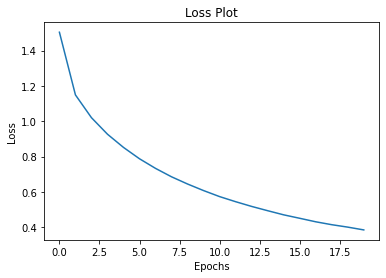

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]
   return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

BELU score: 45.96613576124592
Real Caption: Two white dogs are playing in the snow
Prediction Caption: two white dogs walking in the snow


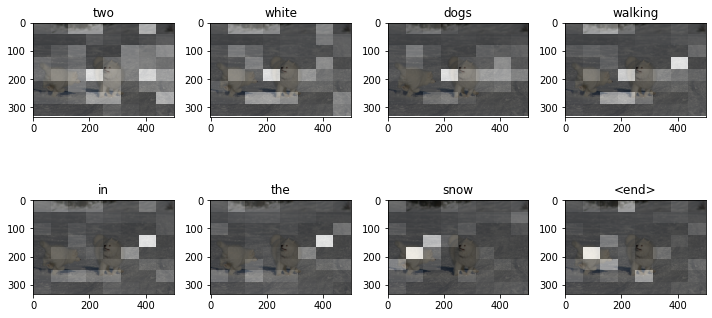

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = '/content/drive/MyDrive/FLICKR8K/FLICKR8K/Images/2319175397_3e586cfaf8.jpg'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
first = real_caption.split(' ', 1)[1]
real_caption = 'Two white dogs are playing in the snow'

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

Real Caption: black dog running through grassy yard carrying large ball in its mouth
Prediction Caption: black dog carries white baseball in its mouth


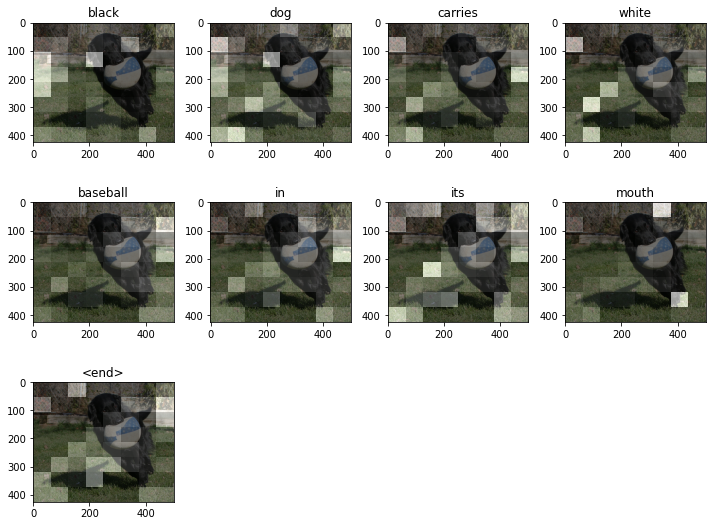

time took to Predict: 1 sec


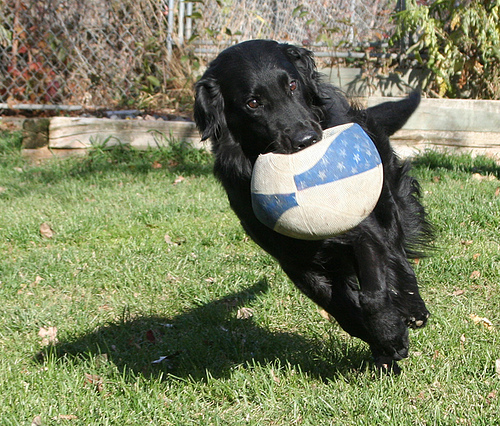

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

BELU score: 25.433143129197212
Real Caption: one dog climbing on the back of another dog in the snow
Prediction Caption: two beige dog is playing in the snow


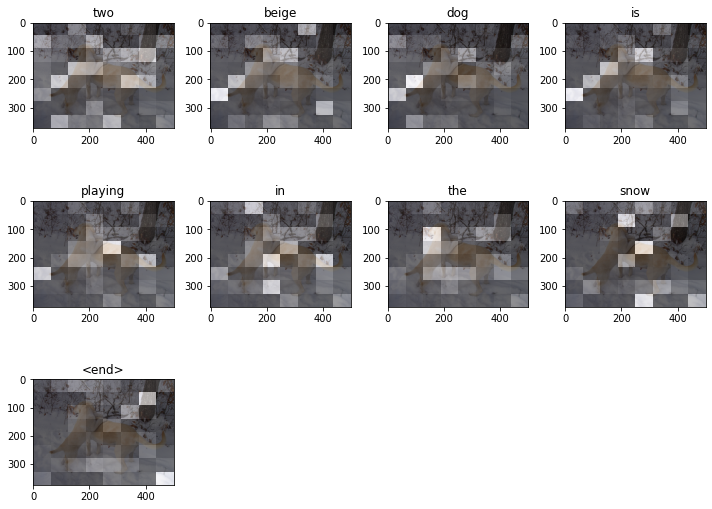

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result        
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)